<b>Forecasting the Weather</b>

In [43]:
# usual imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [44]:
df = pd.read_csv('Weather Data.csv', nrows=500)
# dataset from kaggle, weather data from 2012-2017
# the dataset is very large, so I'm only using the first 500 rows

In [45]:
df.head()

,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
0,1/1/2012 0:00,-1.8,-3.9,86,4,8.0,101.24,Fog
1,1/1/2012 1:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2,1/1/2012 2:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
3,1/1/2012 3:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
4,1/1/2012 4:00,-1.5,-3.3,88,7,4.8,101.23,Fog


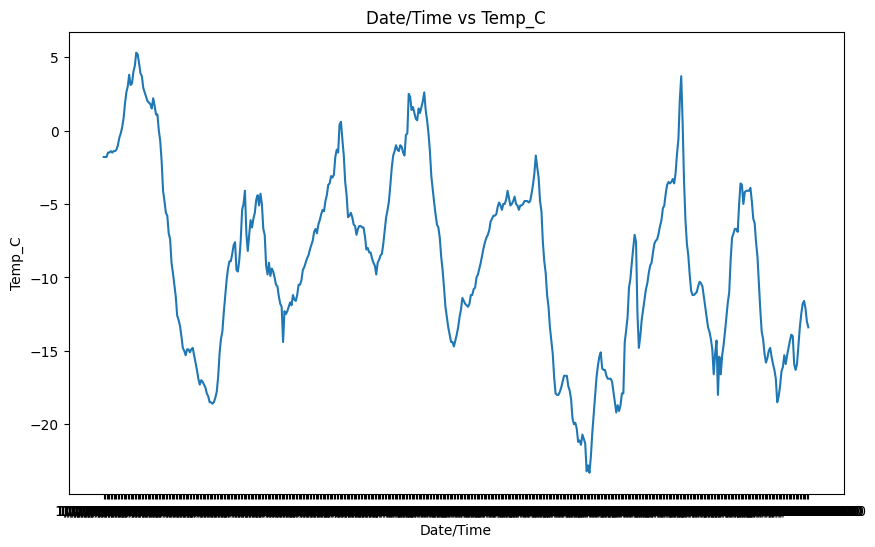

In [46]:
# lets see the graph Date/Time vs Temp_C
plt.figure(figsize=(10,6))
plt.plot(df['Date/Time'], df['Temp_C'])
plt.title('Date/Time vs Temp_C')
plt.xlabel('Date/Time')
plt.ylabel('Temp_C')
plt.show()

In [47]:
# scale the Tempreture value to be between 0 and 1
scaler = MinMaxScaler()
df[['Temp_C']] = scaler.fit_transform(df[['Temp_C']])
df.index = df.index * 0.1 + 1

In [48]:
df.drop(['Dew Point Temp_C'], axis=1, inplace=True)
df.drop(['Rel Hum_%'], axis=1, inplace=True)
df.drop(['Wind Speed_km/h'], axis=1, inplace=True)
df.drop(['Visibility_km'], axis=1, inplace=True)
df.drop(['Press_kPa'], axis=1, inplace=True)
df.drop(['Weather'], axis=1, inplace=True)
# drop all other columns

In [49]:
df.head()

,Date/Time,Temp_C
1.0,1/1/2012 0:00,0.751748
1.1,1/1/2012 1:00,0.751748
1.2,1/1/2012 2:00,0.751748
1.3,1/1/2012 3:00,0.762238
1.4,1/1/2012 4:00,0.762238


<b>X_train, y_train, X_test, y_test</b>

In [50]:
# train test split
cutoff = int(len(df) * 0.70)

# train data
X_train = df.index[0:cutoff]
y_train = df['Temp_C'].iloc[0:cutoff]

# test data
X_test = df.index[cutoff:]
y_test = df['Temp_C'].iloc[cutoff:]


# convert to NumPy -array -format (expected by the generators)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

n_features = 1

# decided to reshape the data as I suppose the model will expect it to be in a certain format
train_series = y_train.reshape((len(y_train), n_features))
test_series  = y_test.reshape((len(y_test), n_features))

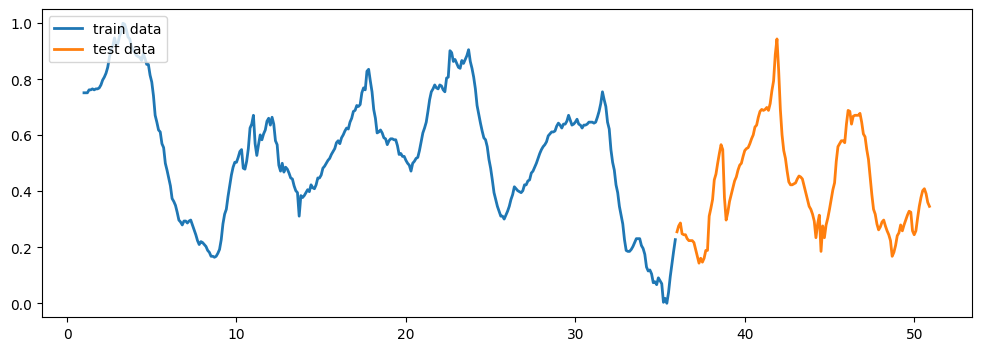

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(X_train, y_train, lw=2, label='train data')
ax.plot(X_test, y_test,  lw=2, label='test data')
ax.legend(loc="upper left")
plt.show()
# test and train data

In [52]:
# TimeseriesGenerators, for train and test
from keras.preprocessing.sequence import TimeseriesGenerator

# this is the time step size
# so if we have 1000 points, and look_back is 20 => 50 time steps
look_back  = 10

# using 1 => using time steps
# anything over 1 => using windowing
window_size = 1

# the amount of data fed to the neural network
# while training. the bigger it is, faster the training
# but with forecasts it also affects the performance
batch_size = 1

train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      # sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      # sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

In [53]:
from keras.models import Sequential
from keras.layers import Dense

# rule of thumb: RNN is usually good with short-term trends
# while LSTM is usually good with long-term trends
# depends on the situation which one suits your dataset better
from keras.layers import LSTM
from keras.layers import SimpleRNN

# make a simple LSTM -network
# you can adjust the number of neurons
# you can also try SimpleRNN
model = Sequential()
model.add(LSTM(24, activation="relu", input_shape=(look_back, n_features)))
#model.add(SimpleRNN(60, activation="relu", input_shape=(look_back, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', mode='min', save_best_only=True)

# have all callbacks in a list
# this time we only have one
callback_list = [mc]
# start training the data, use also validation data for metrics later
model.fit(train_generator, epochs=200, verbose=1, validation_data=test_generator, callbacks=callback_list)

Epoch 1/200
340/340 [==============================] - 2s 4ms/step - loss: 0.0440 - val_loss: 0.0101
Epoch 2/200
340/340 [==============================] - 1s 3ms/step - loss: 0.0071 - val_loss: 0.0117
Epoch 3/200
340/340 [==============================] - 1s 3ms/step - loss: 0.0056 - val_loss: 0.0078
Epoch 4/200
340/340 [==============================] - 1s 3ms/step - loss: 0.0044 - val_loss: 0.0069
Epoch 5/200
340/340 [==============================] - 1s 3ms/step - loss: 0.0032 - val_loss: 0.0059
Epoch 6/200
340/340 [==============================] - 1s 3ms/step - loss: 0.0026 - val_loss: 0.0053
Epoch 7/200
340/340 [==============================] - 1s 3ms/step - loss: 0.0025 - val_loss: 0.0048
Epoch 8/200
340/340 [==============================] - 1s 3ms/step - loss: 0.0021 - val_loss: 0.0049
Epoch 9/200
340/340 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 10/200
340/340 [==============================] - 1s 3ms/step - loss: 0.0018 - val_lo

In [54]:
from keras.models import load_model
model = load_model('best_model.keras')

In [56]:
test_predictions  = model.predict(test_generator)

140/140 [==============================] - 0s 1ms/step


In [57]:
# training metrics
#loss_df = pd.DataFrame(model.history.history)
#loss_df.plot()

In [58]:
test_predictions  = model.predict(test_generator)
test_predictions

140/140 [==============================] - 0s 2ms/step


array([[0.22399773],
       [0.21675454],
       [0.18814798],
       [0.15931587],
       [0.1338119 ],
       [0.15700117],
       [0.14994185],
       [0.16507249],
       [0.19993086],
       [0.20144543],
       [0.33692616],
       [0.378864  ],
       [0.39775193],
       [0.4715426 ],
       [0.4876875 ],
       [0.52249527],
       [0.55739415],
       [0.5874416 ],
       [0.5523477 ],
       [0.3646661 ],
       [0.25782552],
       [0.3019931 ],
       [0.37172893],
       [0.40558797],
       [0.4287399 ],
       [0.4522627 ],
       [0.4626058 ],
       [0.48700318],
       [0.50484073],
       [0.5075047 ],
       [0.53469956],
       [0.5579784 ],
       [0.56044406],
       [0.55943054],
       [0.5753711 ],
       [0.5962107 ],
       [0.61008984],
       [0.64241534],
       [0.6444751 ],
       [0.6759782 ],
       [0.69780856],
       [0.6978985 ],
       [0.68669647],
       [0.6902323 ],
       [0.69956243],
       [0.6822859 ],
       [0.7171385 ],
       [0.777

In [59]:
X_test[-1]
# the last value in the test data is 50.9

50.900000000000006

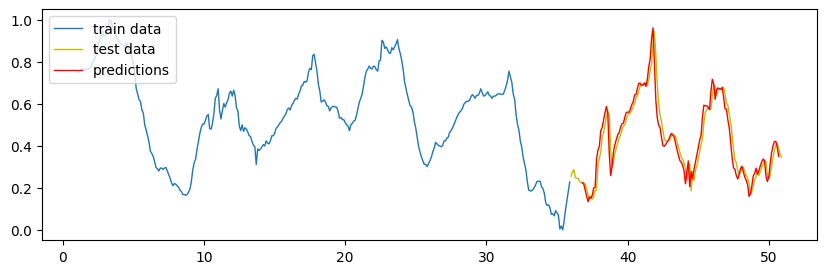

In [60]:
# changed the range to be from 36.8 to 50.8 to match the test data and made it to be 140 steps
x = np.arange(36.8, 50.8, 0.1)
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# the predictions vs test data 
ax.plot(X_train,y_train, lw=1, label='train data')
ax.plot(X_test, y_test, lw=1, c='y', label='test data')
ax.plot(x, test_predictions, lw=1, c='r', label='predictions')
ax.legend(loc="upper left")
plt.show()

# it smees the trend is correct the model predicts temperatures very well, almost identical to the test data

In [61]:
actual_y_test = np.concatenate([y for x, y in test_generator])
errors = np.abs(actual_y_test - test_predictions)
mape = np.mean(errors / actual_y_test) * 100

# print out MAPE-score
print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

# the typical error metrics
# MAE - Mean average error
# MAPE score => less than 10% => excellent result
# MAPE score => 10-20 % => good result
# MAPE score => 20-50% => okay / reasonable / decent result
# negative MAPE score => the model constantly overestimates the values
# MAPE score over 100% => the model constantly underestimates the values
# it's possible to get a weird MAPE result with synthetic test data
# because the data is so predicatble
print("\nMAE")
print(round(metrics.mean_absolute_error(actual_y_test , test_predictions), 2), " units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), " units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(actual_y_test , test_predictions)), 2), " units")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(actual_y_test , test_predictions), 2))
# the model is quite good, as the R-squared value is very close to 1

MAPE (mean average precision error):
6.99 %

MAE
0.02  units

MSE
0.0  units^2

RMSE:
0.04  units

R-squared:
0.96


In [62]:
extrapolation = list()
seed_batch    = y_test[:look_back].reshape((1,look_back, n_features))
current_batch = seed_batch

for i in range(80):
    predicted_value = model.predict(current_batch)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

1/1 [==============================] - 0s 21ms/step


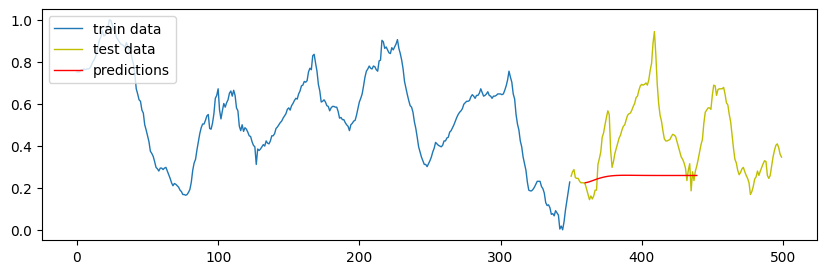

In [63]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(extrapolation) + look_back)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# we can also hide the training data to inspect the
# the predictions vs. test data separately
ax.plot(x1, y_train, lw=1, label='train data')
ax.plot(x2, y_test, lw=1, c='y', label='test data')
ax.plot(x3, extrapolation, lw=1, c='r', label='predictions')
ax.legend(loc="upper left")
plt.show()

# well not the best overall prediction
# tried several different models, and by far the best one was LSTM
# the model was able to predict the test data almost perfectly